In [ ]:
# This code is using all batches of unlabelled data and for 25000 iterations

Checking available free gpu

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       739Mi        11Gi       1.0Mi       880Mi        11Gi
Swap:             0B          0B          0B


Increase the Available GPU limit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip DatasetTG50.zip

In [4]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import (Conv2D, Dense, Flatten, Input,
                                     Activation, Reshape, Conv2DTranspose,
                                     BatchNormalization, LeakyReLU, Dropout,
                                     Embedding, Concatenate, UpSampling2D, MaxPool2D)

from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import datetime
from IPython import display
from tensorflow.python.framework.ops import get_gradient_function
# from alz_classifier import classifier_eff, classifier_cnn
# tf.config.run_functions_eagerly(True)
import pandas as pd

from os import listdir
from os.path import join, isdir

In [5]:
z_dim = 100
# batch_size = 1
DEFAULT_PATH = r"/content/DatasetTG50"
LABELLED_PATH = os.path.join(DEFAULT_PATH,'labelled')
UNLABELLED_PATH = os.path.join(DEFAULT_PATH,'unlabelled')

genimages_dir = "gen_images"

if not os.path.exists(genimages_dir):
    os.makedirs(genimages_dir, exist_ok=True)

img_height=img_width=128
batch_size=256
mini_steps = 1000

class_name = np.array([f for f in listdir(LABELLED_PATH) if isdir(join(LABELLED_PATH, f))])
n_classes = len(class_name)

Found 3200 files belonging to 4 classes.
Using 2560 files for training.
Found 3200 files belonging to 4 classes.
Using 640 files for validation.
Found 3200 files belonging to 1 classes.

Number of Labelled Images: 2560
Number of Validation Images: 640
Number of Unlabelled Images: 3200


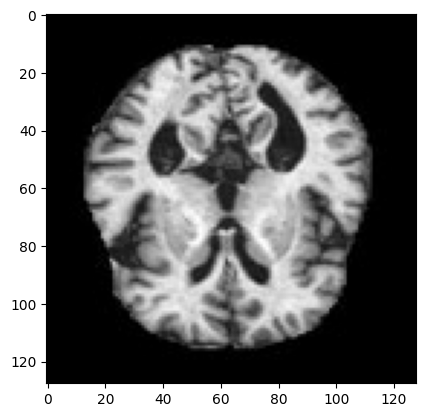

In [6]:
label_data = image_dataset_from_directory(LABELLED_PATH,
                  validation_split=0.2,
                  subset='training',
                  seed=123,
                  color_mode='grayscale',
                  interpolation="nearest",
                  follow_links=False,
                  image_size=(img_height, img_width),
                  batch_size=batch_size,
                  shuffle=True)


val_data = image_dataset_from_directory(LABELLED_PATH,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        color_mode="grayscale",
                                        interpolation="nearest",
                                        follow_links=False,
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size)

unlabel_data = image_dataset_from_directory(UNLABELLED_PATH,
                  validation_split=None,
                  seed=123,
                  color_mode='grayscale',
                  interpolation="nearest",
                  follow_links=False,
                  image_size=(img_height, img_width),
                  batch_size=batch_size,
                  shuffle=True)

def get_count(dataset):
    count = 0
    for a, b in dataset:
        count += len(a)
    return count

print(f'\nNumber of Labelled Images: {get_count(label_data)}\nNumber of Validation Images: {get_count(val_data)}\nNumber of Unlabelled Images: {get_count(unlabel_data)}')

a, b  = next(iter(label_data.take(1)))
# a = np.expand_dims(a, axis=1)
plt.imshow(a[0][:,:,0],cmap='gray')

def process(image,label):
    image = tf.cast(((tf.cast(image, tf.float32)/127.5) - 1), tf.float32)
    return image,label

label_data = label_data.map(process)
val_data = val_data.map(process)
unlabel_data = unlabel_data.map(process)

In [7]:
cat_label = Input((1,))
latent_input = Input((z_dim,))

img_rows = 128
img_cols = 128
channels = 1
img_shape = (img_rows, img_cols, channels)

alpha = 0.5
alpha_p = 0.1
alpha_cla_adv = 0.01

gf = 64
df = 64

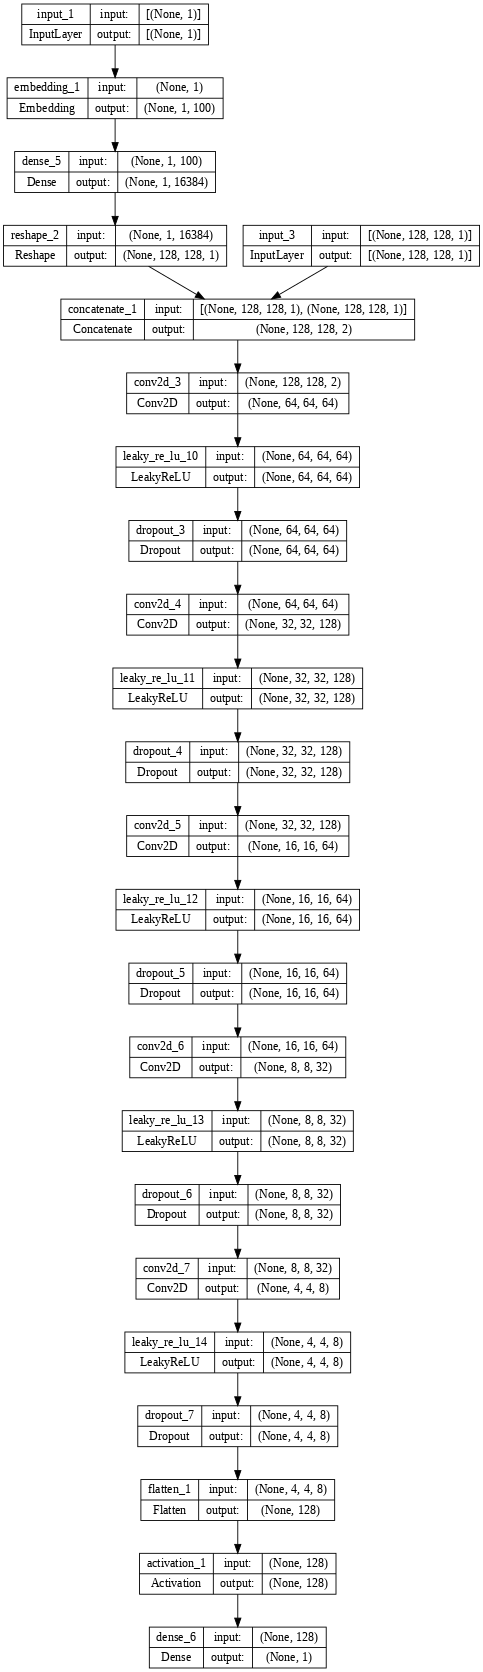

In [8]:
def classifier_cnn():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.20))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(64,'relu'))
    model.add(Dense(4,'softmax'))

    return model

classifier = classifier_cnn()


def conv2d(layer_in,n_filters,f_size=4,batchnorm=True,strides=2):
  # add downsampling layer
  g = Conv2D(n_filters,
              kernel_size=f_size,
              strides=strides,
              padding='same')(layer_in)
  # conditionally add batch normalization
  if batchnorm:
    g = BatchNormalization(momentum=0.8)(g, training=False)
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  return g

# define an dencoder block
def deconv2d(layer_in,skip_in,n_filters,f_size=4,dropout=False):

  # add upsampling layer
  g= UpSampling2D(size=2)(layer_in)

  g = Conv2D(n_filters,
            kernel_size=f_size,
            strides=1,
            padding='same',
            activation='relu')(g)
  # conditionally add dropout
  if dropout:
    g = Dropout(0.5)(g)
  # add batch normalization
  g = BatchNormalization(momentum=0.8)(g)
  # merge with skip connection
  g = Concatenate()([g, skip_in])
  return g


def generator_label_emb(layer_input: Input, num_cat: int = n_classes, embedding_input: int = z_dim):
    label_embedding = Embedding(num_cat, embedding_input)(layer_input)
    d1 = Dense(8 * 8 * 1)(label_embedding)
    layer_reshape = Reshape((8, 8, 1))(d1)

    return layer_reshape


def generator_latent_dim(layer_input: Input, latente_dim: int = z_dim):
    d1 = Dense(8 * 8 * 256)(layer_input)
    d2 = BatchNormalization()(d1)
    d3 = LeakyReLU()(d2)
    layer_reshape = Reshape((8, 8, 256))(d3)

    return layer_reshape


def Input_generator(cat_label, latent_input) -> tf.keras.models.Model:
    gle = generator_label_emb(cat_label)
    gld = generator_latent_dim(latent_input)
    input = Concatenate()([gle, gld])

    return input


def build_generator():
    input = Input_generator(cat_label, latent_input)

    # U-net Generator

    g = Conv2DTranspose(128, 3, 2, 'same')(input)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)

    g = Conv2DTranspose(64, 3, 1, 'same')(input)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)

    g = Conv2DTranspose(64, 3, 2, 'same')(g)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)

    g = Conv2DTranspose(64, 3, 1, 'same')(g)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)

    g = Conv2DTranspose(32, 3, 2, 'same')(g)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)

    g = Conv2DTranspose(32, 3, 1, 'same')(g)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)

    g = Conv2DTranspose(16, 3, 2, 'same')(g)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)

    g = Conv2DTranspose(16, 3, 1, 'same')(g)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)

    g = Conv2DTranspose(16, 3, 2, 'same')(g)
    g = BatchNormalization()(g)
    g = LeakyReLU()(g)
    g = Dropout(0.3)(g)

    g = Conv2DTranspose(1, 3, 1, 'same')(g)
    g = Activation('tanh')(g)

    return Model(inputs=[cat_label, latent_input], outputs=g)


generator = build_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

shape_input = (128, 128, 1)


def discrimimator_label_emb(layer_input: Input, shape_input: tuple() = shape_input, num_cat: int = 10,
                            embedding_input: int = z_dim):
    label_embedding = Embedding(num_cat, embedding_input)(layer_input)
    d1 = Dense(shape_input[0] * shape_input[1] * shape_input[2])(label_embedding)
    layer_reshape = Reshape(shape_input)(d1)

    return layer_reshape


def discrimimator_input(shape_input: tuple() = shape_input, latente_dim: int = z_dim):
    layer_input = Input(shape_input)
    return layer_input


def discriminator():
    layer_label_emb = discrimimator_label_emb(cat_label)
    layer_input = discrimimator_input()
    concate = Concatenate()([layer_label_emb, layer_input])

    d = Conv2D(64, 3, 2, 'same')(concate)
    d = LeakyReLU()(d)
    d = Dropout(0.3)(d)

    d = Conv2D(128, 3, 2, 'same')(d)
    d = LeakyReLU()(d)
    d = Dropout(0.3)(d)

    d = Conv2D(64, 3, 2, 'same')(d)
    d = LeakyReLU()(d)
    d = Dropout(0.3)(d)

    d = Conv2D(32, 3, 2, 'same')(d)
    d = LeakyReLU()(d)
    d = Dropout(0.3)(d)

    d = Conv2D(8, 3, 2, 'same')(d)
    d = LeakyReLU()(d)
    d = Dropout(0.3)(d)

    d = Flatten()(d)
    d = Activation('sigmoid')(d)
    d = Dense(1)(d)

    model = Model(inputs=[layer_input, cat_label], outputs=d, name="discriminator")
    return model


discriminator = discriminator()
tf.keras.utils.plot_model(discriminator, to_file='discriminator.png', show_shapes=True, dpi=64)

In [9]:
generator_optimizer = tf.optimizers.Adam(0.0001)
discriminator_optimizer = tf.optimizers.Adam(0.0001)
classifier_optimizer = tf.optimizers.Adam(0.0001)

default_patch = "./"
checkpoint_dir = default_patch + '/check/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 classifier_optimizer=classifier_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 classifier=classifier)

log_dir = default_patch + "/logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/')
rows = n_classes
cols = 1
noises = np.random.normal(0, 1, (rows * cols, z_dim))
num_labels = np.arange(0, rows).reshape(-1, 1)

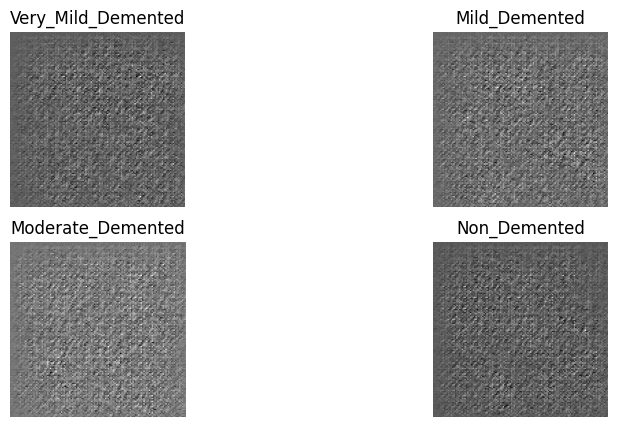

In [10]:
def sample_images(model, id, rows=2, cols=2):
    prediction = model([num_labels, noises], training=False)

    plot, axs = plt.subplots(rows, cols, figsize=(10, 5))

    gen_imgs = [p for p in prediction]
    pos_img = 0
    for r in range(rows):
        for c in range(cols):
            axs[r, c].axis('off')
            axs[r, c].set_title(f'{class_name[pos_img]}')
            axs[r, c].imshow(gen_imgs[pos_img][:, :, 0] * 0.5 + 0.5, cmap='gray')
            pos_img += 1
    # plt.show()
    plt.savefig(os.path.join(genimages_dir,f'generate_image_{id}.png'))


sample_images(model=generator, id=00)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
class_loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def discrimantor_loss(disc_fake, disc_real, step):
    loss_disc_real = loss_object(tf.ones_like(disc_real), disc_real)

    loss_disc_fake = (1-alpha)*loss_object(tf.zeros_like(disc_fake), disc_fake)


    loss_disc = (loss_disc_real + loss_disc_fake)

    return loss_disc, loss_disc_real, loss_disc_fake


def generator_loss(gen_out, step):
    loss_gen_out = (1-alpha)*loss_object(tf.ones_like(gen_out), gen_out)

    with summary_writer.as_default():
        tf.summary.scalar('loss_gen_out', loss_gen_out, step=step // mini_steps)


    return loss_gen_out

def classifier_loss(class_real, class_fake, input_label, step):
    loss_class_real = class_loss_object(input_label, class_real)
    loss_class_fake = class_loss_object(input_label, class_fake)


    loss_class = loss_class_real + alpha_p * loss_class_fake

    return loss_class, loss_class_real, loss_class_fake

In [11]:
@tf.function
def train_step(input_image, input_label, unlabel_data, generator, discriminator, classifier, step, disc_unlab_loss, clas_unlab_loss):
    z_noise = np.random.normal(0, 1, (input_label.shape[0], z_dim))

    assert z_noise.shape == (input_label.shape[0], z_dim)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_real, tf.GradientTape() as disc_tape_fake, \
            tf.GradientTape() as class_tape_real, tf.GradientTape() as class_tape_fake:

        # Train Generator
        gen_out = generator([input_label, z_noise], training=True)

        # Train Discriminator
        disc_fake = discriminator([gen_out, input_label], training=True)
        disc_real = discriminator([input_image, input_label], training=True)


        # Loss Generator
        loss_gen_out = generator_loss(disc_fake, step)

        # Train Classifier
        class_real = classifier(input_image, training=True)
        class_fake = classifier(gen_out, training=True)


        ################################################################################################################
        #  TRAINING USING UNLABELLED DATA ONLY AT EACH 100 STEP
        ################################################################################################################
        if ((step + 1) % mini_steps == 0):

            # unlab_batch = 0
            for unlab_image, _ in unlabel_data:
                # if unlab_batch == 3:
                #     break
                # unlab_batch += 1
                with tf.GradientTape() as disc_tape_unlab:

                    pseudo_label = tf.random.uniform([len(unlab_image)], minval=0, maxval=n_classes, dtype=input_label.dtype)

                    class_unlab = classifier(unlab_image, training=True)
                    disc_unlab = discriminator([unlab_image, pseudo_label], training=True)

                    # ublabel loss for this batch
                    max_c = tf.math.argmax(class_unlab, axis=1)
                    max_c = tf.cast(max_c,dtype=tf.float32)

                    d_u_loss = loss_object(tf.ones_like(disc_unlab), disc_unlab)


                    loss_disc_unlab = alpha*tf.reduce_mean(max_c * d_u_loss)

                    #get the sum of unlabel losses
                    disc_unlab_loss += d_u_loss
                    clas_unlab_loss += loss_disc_unlab

                # Discriminator Gradiente to Unlabel images
                discriminator_gradients = disc_tape_unlab.gradient(loss_disc_unlab, discriminator.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

            ################################################################################################################

            # Loss Discriminator
            #average of unlabel losses for discriminator
            disc_unlab_loss = disc_unlab_loss/tf.cast(len(unlabel_data), tf.float32)
            loss_disc_unlab = alpha * disc_unlab_loss

            loss_disc, loss_disc_real, loss_disc_fake = discrimantor_loss(disc_fake, disc_real, step)

            #total loss for disc ---TO PRINT
            loss_disc_new = loss_disc+loss_disc_unlab

            # if add_summary:
            # with summary_writer.as_default():
            #     tf.summary.scalar('loss_disc_real', loss_disc_real, step=step // mini_steps)
            #     tf.summary.scalar('loss_disc_fake', loss_disc_fake, step=step // mini_steps)
            #     tf.summary.scalar('loss_disc_new', loss_disc_new, step=step // mini_steps)
            ################################################################################################################

            # Loss Classifier
            # average of unlabel losses for classifier
            clas_unlab_loss = clas_unlab_loss / tf.cast(len(unlabel_data), tf.float32)

            loss_clas_unlab = alpha_cla_adv * alpha * clas_unlab_loss
            loss_class, loss_class_real, loss_class_fake = classifier_loss(class_real, class_fake, input_label, step)

            #total loss for class --- TO PRINT
            loss_class_new = loss_class + loss_clas_unlab
            # with summary_writer.as_default():
            #     tf.summary.scalar('loss_class_real', loss_class_real, step=step // mini_steps)
            #     tf.summary.scalar('loss_class_fake', loss_class_fake, step=step // mini_steps)
            #     tf.summary.scalar('loss_class_new',loss_class_new, step=step // mini_steps)
            ################################################################################################################

        else:   ###### STEPS OTHER THAN 100s
            # Loss Discriminator
            loss_disc, loss_disc_real, loss_disc_fake = discrimantor_loss(disc_fake, disc_real, step)

            # total loss for disc ---TO PRINT
            loss_disc_new = loss_disc

            # with summary_writer.as_default():
            #     tf.summary.scalar('loss_disc_real', loss_disc_real, step=step // mini_steps)
            #     tf.summary.scalar('loss_disc_fake', loss_disc_fake, step=step // mini_steps)
            #     tf.summary.scalar('loss_disc_new', loss_disc_new, step=step // mini_steps)
            ################################################################################################################

            # Loss Classifier
            loss_class, loss_class_real, loss_class_fake = classifier_loss(class_real, class_fake, input_label, step)

            # total loss for class --- TO PRINT
            loss_class_new = loss_class
            # with summary_writer.as_default():
            #     tf.summary.scalar('loss_class_real', loss_class_real, step=step // mini_steps)
            #     tf.summary.scalar('loss_class_fake', loss_class_fake, step=step // mini_steps)
            #     tf.summary.scalar('loss_class_new', loss_class_new, step=step // mini_steps)

    # Generator Gradiente
    generator_gradients = gen_tape.gradient(loss_gen_out, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    # Discriminator Gradiente to real imagens
    discriminator_gradients = disc_tape_real.gradient(loss_disc_real, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Discriminator Gradiente to fake imagens
    discriminator_gradients = disc_tape_fake.gradient(loss_disc_fake, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Classifier Gradients to real images
    classifier_gradients = class_tape_real.gradient(loss_class_real, classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(classifier_gradients, classifier.trainable_variables))

    # Classifier Gradients to fake images
    classifier_gradients = class_tape_fake.gradient(loss_class_fake, classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(classifier_gradients, classifier.trainable_variables))

    return loss_disc_new, loss_gen_out, loss_class_new

def mean(input_list):
    return (sum(input_list)/len(input_list))

def val_step(classifier, val_data):

    val_losses, val_scores= [],[]
    for num, data in val_data.enumerate():
        val_image, val_label = data[0], data[1]
        class_out = classifier(val_image, training=False)

        #val loss
        val_loss = tf.keras.losses.SparseCategoricalCrossentropy()(val_label, class_out)

        #val score
        pred_class = tf.math.argmax(class_out, axis=1)
        val_score = (pred_class.numpy()==(val_label.numpy())).sum() / len(val_label)

        val_losses.append(val_loss)
        val_scores.append(val_score)

    return (np.array(val_losses)).mean(), (np.array(val_scores)).mean()

In [12]:
def fit(interations):
    step_l, gl_l, dl_l, cl_l, vl_l, vs_l = [], [], [], [], [], []
    start = datetime.datetime.now()
    start_1k = datetime.datetime.now()
    d_loss, g_loss, c_loss= [], [], []
    for (step, input_image) in label_data.repeat().take(interations).enumerate():
        disc_unlab_loss = tf.Variable(trainable=False, dtype=tf.float32, initial_value=0.0)
        clas_unlab_loss = tf.Variable(trainable=False, dtype=tf.float32, initial_value=0.0)
        loss_disc, loss_gen_out, loss_class = train_step(input_image[0], input_image[1], unlabel_data, generator, discriminator, classifier, step, disc_unlab_loss, clas_unlab_loss)
        d_loss.append(loss_disc.numpy().item())
        g_loss.append(loss_gen_out.numpy().item())
        c_loss.append(loss_class.numpy().item())


        if ((step + 1) % mini_steps == 0):

            #test the models with validation data
            val_loss, val_score = val_step(classifier, val_data)
            print(f"\nStep: {(step+1)//mini_steps} -- Disc Loss: {mean(d_loss)}, Gen Loss: {mean(g_loss)}, Class Loss: {mean(c_loss)}, Val Loss: {val_loss}, Val Score: {val_score}")


            checkpoint.save(file_prefix=checkpoint_prefix)
            # display.clear_output(wait=True)
            print(f'Time per 1k steps:{datetime.datetime.now() - start_1k}')
            start_1k = datetime.datetime.now()
            print(f'step: {(step + 1) // mini_steps}k')
            sample_images(generator, step+1)
            print(f'Total time:{datetime.datetime.now() - start}')
            step_l.append((step+1)//mini_steps)
            gl_l.append(mean(g_loss))
            dl_l.append(mean(d_loss))
            cl_l.append(mean(c_loss))
            vl_l.append(val_loss)
            vs_l.append(val_score)

            train_history_df = pd.DataFrame({"step": step_l, "gloss": gl_l, "dloss": dl_l, "closs": cl_l, "vloss": vl_l, "vscore": vs_l})
            train_history_df.to_csv("train_history.csv")

            d_loss, g_loss, c_loss = [], [], []

            tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')

            tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')

            tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) // mini_steps}_v2.h5')

In [ ]:
fit(25000)


Step: 1 -- Disc Loss: 0.9628095561265946, Gen Loss: 0.1888385846503079, Class Loss: 0.8517833523452282, Val Loss: 0.4950313866138458, Val Score: 0.80078125
Time per 1k steps:0:16:03.492451
step: 1k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:0:16:03.772749

Step: 2 -- Disc Loss: 0.9600367065668106, Gen Loss: 0.19907689076662063, Class Loss: 0.3459215749949217, Val Loss: 0.1825094223022461, Val Score: 0.9270833333333334
Time per 1k steps:0:15:32.727728
step: 2k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:0:31:36.650272

Step: 3 -- Disc Loss: 0.9588398978710174, Gen Loss: 0.19822958953678607, Class Loss: 0.18004310358315706, Val Loss: 0.08707890659570694, Val Score: 0.9752604166666666
Time per 1k steps:0:15:32.622724
step: 3k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:0:47:09.250956

Step: 4 -- Disc Loss: 0.957000697851181, Gen Loss: 0.19900093330442906, Class Loss: 0.17649384206533433, Val Loss: 0.13004352152347565, Val Score: 0.9609375
Time per 1k steps:0:15:31.823147
step: 4k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:1:02:41.253401

Step: 5 -- Disc Loss: 0.9560381466150284, Gen Loss: 0.19954027280211448, Class Loss: 0.150982469804585, Val Loss: 0.1836984008550644, Val Score: 0.9388020833333334
Time per 1k steps:0:15:31.349277
step: 5k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:1:18:12.301103

Step: 6 -- Disc Loss: 0.9560420981049538, Gen Loss: 0.1999279694110155, Class Loss: 0.0872494529299438, Val Loss: 0.06577128916978836, Val Score: 0.9830729166666666
Time per 1k steps:0:15:31.920305
step: 6k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:1:33:44.216856

Step: 7 -- Disc Loss: 0.9551318510174751, Gen Loss: 0.20008030708134175, Class Loss: 0.12711678530648352, Val Loss: 0.10075795650482178, Val Score: 0.9635416666666666
Time per 1k steps:0:15:31.420186
step: 7k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:1:49:15.749795

Step: 8 -- Disc Loss: 0.955481294631958, Gen Loss: 0.20014250290393829, Class Loss: 0.0896275589838624, Val Loss: 0.0728629007935524, Val Score: 0.9765625
Time per 1k steps:0:15:31.673357
step: 8k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:2:04:47.310126

Step: 9 -- Disc Loss: 0.9551156852841377, Gen Loss: 0.2002226361632347, Class Loss: 0.10464318208768963, Val Loss: 0.05250212177634239, Val Score: 0.9830729166666666
Time per 1k steps:0:15:32.076779
step: 9k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:2:20:19.392670

Step: 10 -- Disc Loss: 0.9552222710251809, Gen Loss: 0.20034845316410066, Class Loss: 0.06871720448695123, Val Loss: 0.37948909401893616, Val Score: 0.84375
Time per 1k steps:0:15:32.031404
step: 10k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:2:35:51.564369

Step: 11 -- Disc Loss: 0.954860192656517, Gen Loss: 0.20085227048397064, Class Loss: 0.08001072991266847, Val Loss: 0.11135131865739822, Val Score: 0.9635416666666666
Time per 1k steps:0:15:31.205570
step: 11k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:2:51:22.625023

Step: 12 -- Disc Loss: 0.9545068027377128, Gen Loss: 0.20086691357195377, Class Loss: 0.07078588773310185, Val Loss: 0.09368526935577393, Val Score: 0.9752604166666666
Time per 1k steps:0:15:31.711962
step: 12k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:3:06:54.336713

Step: 13 -- Disc Loss: 0.9552105424404145, Gen Loss: 0.20060223899781704, Class Loss: 0.03203553300257772, Val Loss: 0.08922728151082993, Val Score: 0.9791666666666666
Time per 1k steps:0:15:32.003191
step: 13k


<ipython-input-12-202546b896c4>:41: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')
<ipython-input-12-202546b896c4>:45: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) 

Total time:3:22:26.342890


In [1]:
tf.keras.models.save_model(discriminator,f'/content/gen_images/disc_{(step + 1) // mini_steps}_v2.h5')

NameError: ignored

In [ ]:
tf.keras.models.save_model(generator,f'/content/gen_images/gen_{(step + 1) // mini_steps}_v2.h5')

In [ ]:
tf.keras.models.save_model(classifier,f'/content/gen_images/cls_{(step + 1) // mini_steps}_v2.h5')
